# Adaptive PDE discretizations on Cartesian grids
## Volume : Reproducible research
## Part : Eikonal CPU/GPU solvers comparison
## Chapter : Curvature penalized models

In this notebook, we solve non-holonomic eikonal equations on the CPU and GPU, related to curvature penalized models.
Our purpose is to establish that the schemes produce consistent results.

[**Summary**](Summary.ipynb) of volume Reproducible research, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Constant cost](#1.-Constant-cost)
    * [1.1 Elastica](#1.1-Elastica)
    * [1.2 Reeds-Shepp](#1.2-Reeds-Shepp)
    * [1.3 ReedsShepp forward](#1.3-ReedsShepp-forward)
    * [1.4 Dubins](#1.4-Dubins)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Curvature_GPU','Repro'))

In [2]:
from agd import AutomaticDifferentiation as ad
if ad.cupy_generic.cp is None: raise ad.DeliberateNotebookError('Cupy module required')
from agd import Eikonal
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd.Plotting import savefig; #savefig.dirName = 'Figures/Curvature_GPU'; savefig.dpi=150
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from agd.ExportedCode.Notebooks_Repro.Isotropic_GPU import RunCompare

DeliberateNotebookError: Cupy module required

In [3]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [4]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global Eikonal,ad,cugen,RunGPU,RunSmart,Metrics
    Eikonal,ad,cugen,Metrics = rreload([EIkonal,ad,cugen,Metrics],"../..")    
    Eikonal.dictIn.default_mode = 'gpu'

In [5]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
Eikonal.dictIn.default_mode = 'gpu'

### 0.1 Additional configuration

In [17]:
large_instances = False

In [18]:
random_tips_seed = 42 # None : use four orientations. Integer : use random orientations. 

## 1. Constant cost

### 1.1 Elastica
The Euler elastica model is my favorite for the beauty of the curves it creates. However, it is also the hardest to accelerate on the GPU, due to the very wide stencils used.

In [19]:
n = 300 if large_instances else 100 
nTheta = 96 if large_instances else 64
hfmIn = Eikonal.dictIn({
    'model':'Elastica2',
    'seeds':cp.array([[0.,0.,np.pi]]),
    'exportValues':1,
    'cost':1,
    'xi':0.4,
    'count_updates':True,
#    'solver':'fast_iterative_method','fim_front_width':5,#'traits':{'niter_i':4},
})
hfmIn.SetRect([[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True)
hfmIn.nTheta=nTheta

In [20]:
if random_tips_seed is None: 
    hfmIn.SetUniformTips((4,4,4))
else: 
    hfmIn.SetUniformTips((4,4,1))
    np.random.seed(random_tips_seed)
    hfmIn['tips'][:,2] = 2.*np.pi*cp.asarray(np.random.rand(len(hfmIn['tips'])))

In [10]:
#gpuOut = hfmIn.Run()

In [11]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.02,check_ratio=0.01)

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.26314544677734375 seconds, and 164 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 2.191 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Ended Geodesic Discrete Solver
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.26314544677734375, CPU : 2.1929999999999996. Device acceleration : 8.333794207184482
Max |gpuValues-cpuValues| :  1.505280520444825


In [12]:
assert all(stop in ('AtSeed','PastSeed') for stop in gpuOut['geodesic_stopping_criteria'])

In [13]:
#np.sum(np.abs(gpuOut['values'].get()-cpuOut['values'])>0.02)/gpuOut['values'].size

The mean number of updates of any block.

In [14]:
np.mean(gpuOut['stats']['eikonal']['nupdate_o'])

array( 19.6)

In [15]:
def show():
    """Displays the geodesics, and their tips, as stored in hfmIn, gpuOut"""
    fig = plt.figure(figsize=[15,15])
    
    # Show projections of geodesics and their tips
    for geo in gpuOut['geodesics']: plt.plot(geo[0],geo[1]) 
    plt.scatter(*hfmIn['tips'].T[:2],color='black')
    

    # No axes labels, equal scales
    plt.axis('equal')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    return fig

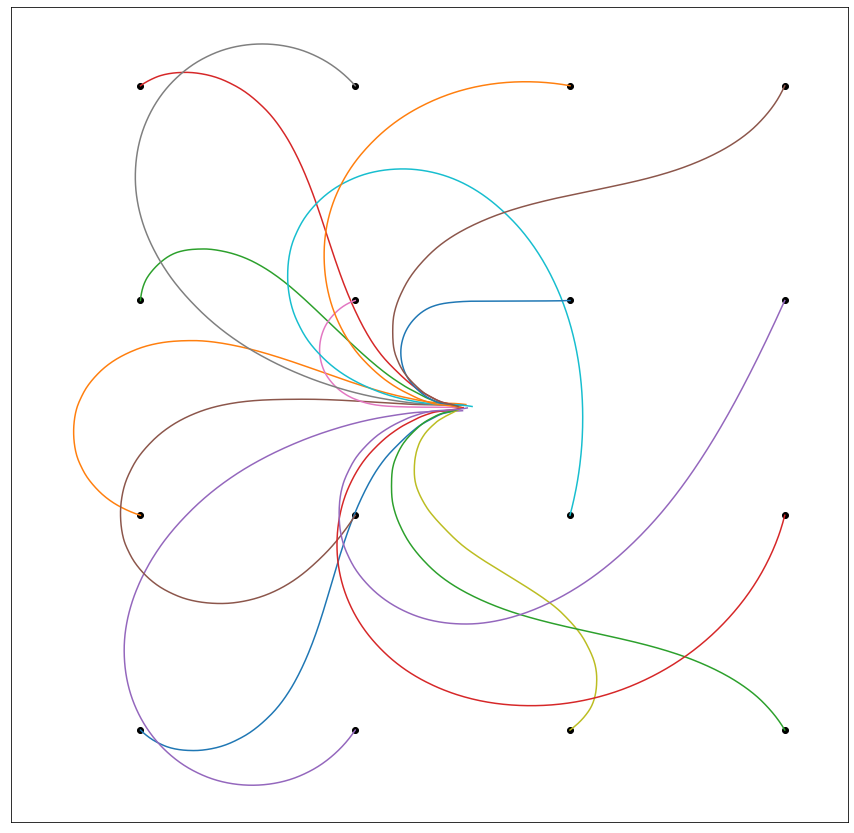

In [16]:
fig = show()
savefig(fig,'Elastica.png')

### 1.2 Reeds-Shepp

In [19]:
hfmIn['model']='ReedsShepp2'

In [20]:
#gpuOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.3999302387237549 seconds, and 94 iterations.
Post-Processing


In [143]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.002,check_ratio=0.04) 

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.4109005928039551 seconds, and 94 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field eps defaults to 0.1
Field projective defaults to 0
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 14.801 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Ended Geodesic Discrete Solver
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.4109005928039551, CPU : 14.827. Device acceleration : 36.08415334429589
Max |gpuValues-cpuValues| :  0.003224447084680282


In [161]:
assert all(stop=='AtSeed' for stop in gpuOut['geodesic_stopping_criteria'])

The number of updates per block

In [162]:
np.mean(gpuOut['stats']['eikonal']['nupdate_o'])

array( 12.8)

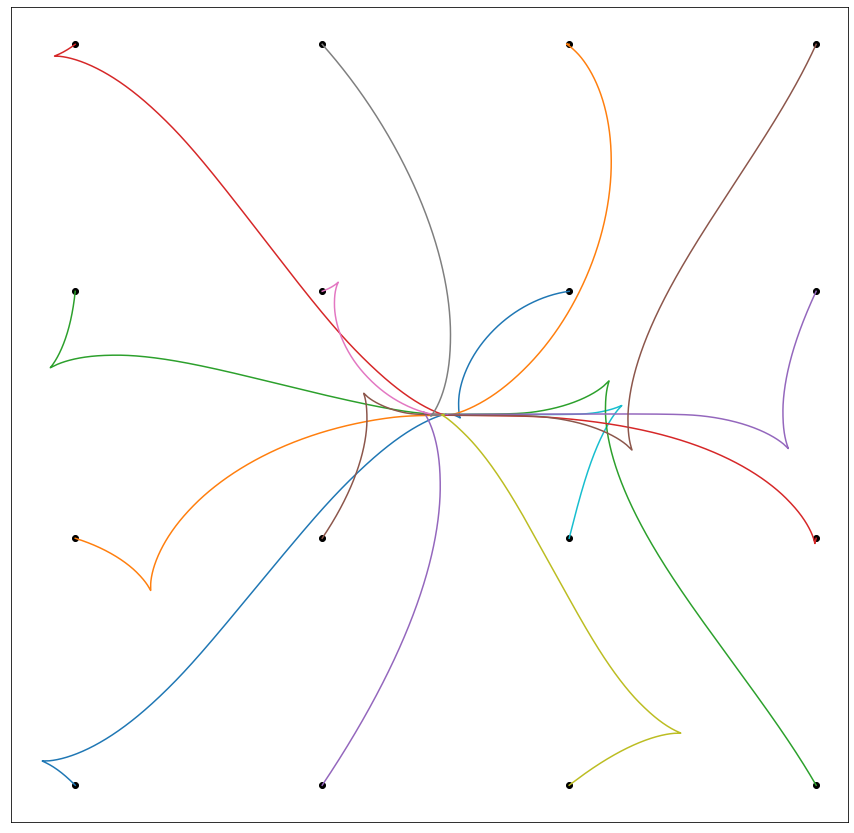

In [22]:
fig=show()
savefig(fig,"ReedsShepp.png")

### 1.3 ReedsShepp forward

In [21]:
hfmIn['model']='ReedsSheppForward2'

In [22]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.2182471752166748 seconds, and 127 iterations.
Post-Processing


In [23]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.005,check_ratio=0.004) 

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.03127288818359375 seconds, and 58 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.276 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Ended Geodesic Discrete Solver
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.03127288818359375, CPU : 0.278. Device acceleration : 8.889489143693584
Max |gpuValues-cpuValues| :  0.21157774249867334


In [23]:
np.mean(gpuOut['stats']['eikonal']['nupdate_o'])

array( 7.17)

In [24]:
# Stationnary deserves investigation...
assert all(stop in ('AtSeed','PastSeed','Stationnary') for stop in gpuOut['geodesic_stopping_criteria'])

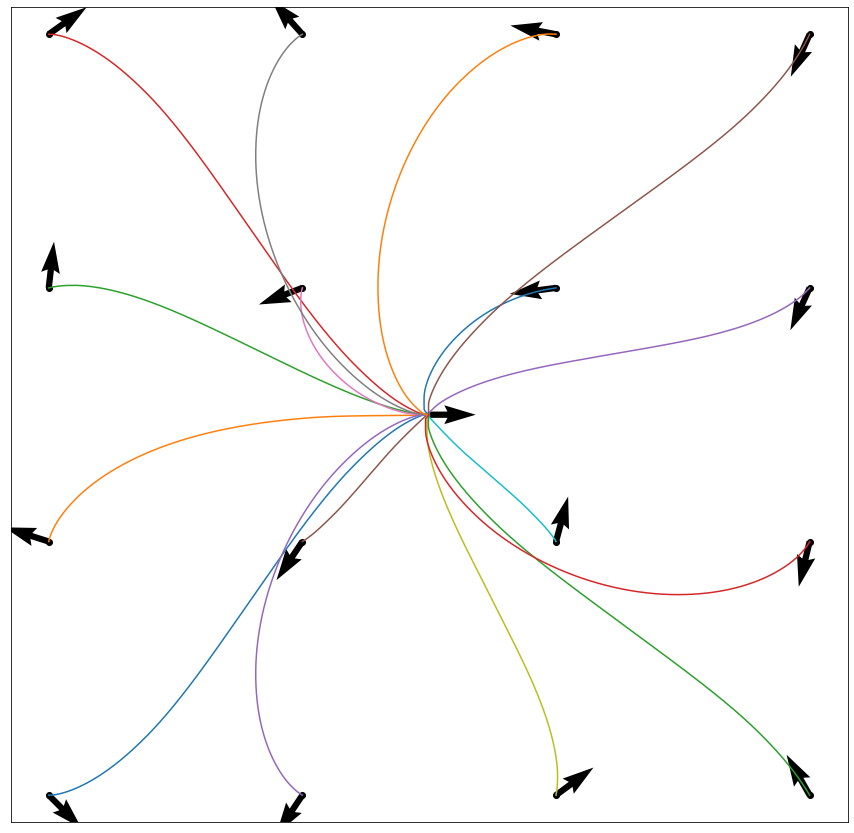

In [27]:
fig=show()
tips = hfmIn['tips'].T
plt.quiver(*tips[:2],-np.cos(tips[2]),-np.sin(tips[2]))
plt.quiver(0.,0.,1.,0.);
savefig(fig,"ReedsSheppForward.png")

### 1.4 Dubins

In [24]:
hfmIn['model']='Dubins2'
hfmIn['geodesic_targetTolerance']=15 # Increased to avoid one target miss

In [25]:
gpuOut = hfmIn.Run()

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.478748083114624 seconds, and 205 iterations.
Post-Processing


In [27]:
gpuOut,cpuOut = RunCompare(hfmIn,check=0.005,check_ratio=0.02) #check=0.005,check_ratio=0.004) 

Setting the kernel traits.
Preparing the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0690608024597168 seconds, and 101 iterations.
Post-Processing
--- gpu done, turning to cpu ---
Field verbosity defaults to 1
Field eps defaults to 0.1
Field order defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 1.221 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 10.985
Ended Geodesic Discrete Solver
***** Warning ! *****
Unused fields from user: count_updates 
********************
Solver time (s). GPU : 0.0690608024597168, CPU : 1.223. Device acceleration : 17.709032568994207
Max |gpuValues-cpuValues| :  0.0531112294427909


Some points of the domain are not reached by the front propagation, due to the non-locally controllable nature of the model.
No geodesic can be extracted from these points, and the stopping criterion is set to 'InWall'.

In [28]:
assert all(stop in ('AtSeed','PastSeed','InWall') for stop in gpuOut['geodesic_stopping_criteria'])

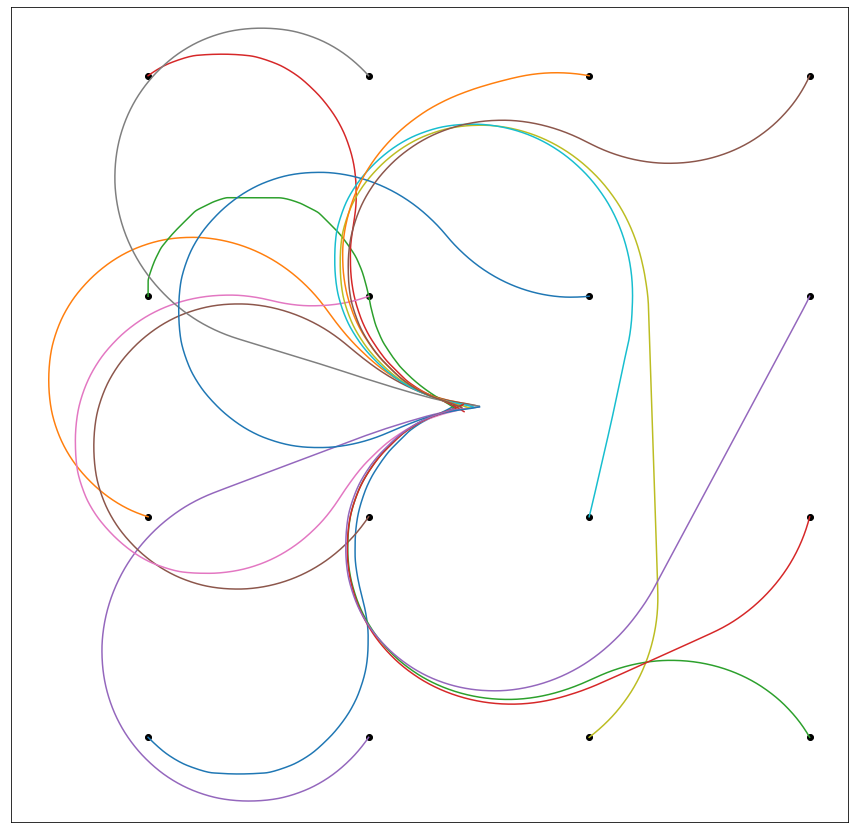

In [26]:
fig=show()
savefig(fig,"Dubins.png")